In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

What are returns? https://www.investopedia.com/terms/i/intraday-return.asp#:~:text=However%2C%20it's%20still%20worth%20knowing,number%20of%20shares%20you%20own

In [25]:
#not finished
def EWMA_per_bitcoin(bitcoin, binance_data):
    #isolating bitcoing data
    bitcoin_df = binance_data[binance_data.currency_pair == bitcoin].reset_index().drop(['index','currency_pair'],axis=1)
    #calculating GK model from the paper's formula
    bitcoin_df['GK_model'] = .5 * (np.power( np.log(bitcoin_df['high']/bitcoin_df['low']) ,2) ) \
                        - (2*np.log(2) - 1) * np.power(np.log(bitcoin_df['close']/bitcoin_df['open']),2)
    #calculating returns based on daily opening and closing values
    bitcoin_df['returns'] = bitcoin_df.open - bitcoin_df.close
    bitcoin_df['date'] = [ele[:8] for ele in bitcoin_df['timestamp']]
    bitcoin_df['hour'] = [ele[-5:-3] for ele in bitcoin_df['timestamp']]
    #grabs only the 10s place to make averageing for the time period easier 
    bitcoin_df['tens_minute'] = [ele[-2:-1] for ele in bitcoin_df['timestamp']]    
    #Averaging returns/GK_model at the 10 minute and daily levels    
    bitcoin_df_daily_ave = bitcoin_df.groupby(['date'])['GK_model'].mean().reset_index() 
    bitcoin_df_10_min_ave = bitcoin_df.groupby(['date','hour','tens_minute']).mean().reset_index()
    #adding the daily GK averages to the 10 minute averages to make caclulations easier 
    bitcoin_df_10_min_ave = bitcoin_df_10_min_ave.join(bitcoin_df_daily_ave.set_index('date'),on='date',lsuffix='_10_min_ave', rsuffix='_daily_ave')
    #when getting the intraday returns do not forget to take sqrt of GKmodel    
    #sqrt of how many 10 minute intervals are in a day
    N = (24/(1/6))**.5 
    GK_model_daily_ave = np.sqrt(bitcoin_df_10_min_ave.GK_model_daily_ave)
    GK_model_10_min_ave = np.sqrt(bitcoin_df_10_min_ave.GK_model_10_min_ave)
    # filling a column with gaussian random variables
    Z = np.random.normal(0, 1, GK_model_10_min_ave.size) 
    returns = bitcoin_df_10_min_ave.returns
    bitcoin_df_10_min_ave['calculated_returns'] = returns + (GK_model_daily_ave*GK_model_10_min_ave*Z)/N    
    #paper recommended .94 as the decay factor but we may want to use a smaller decay
    decay_factor = .94
    GK_model_daily_ave = bitcoin_df_daily_ave.GK_model
    daily_returns = bitcoin_df_10_min_ave.groupby(['date'])['calculated_returns'].mean().reset_index()
    daily_returns = daily_returns.calculated_returns**2
    #calculating the EWMA based on the equation provided in the paper
    bitcoin_df_daily_ave['EWMA'] = decay_factor*GK_model_daily_ave + (1-decay_factor)*daily_returns
    #sorting the table by time
    bitcoin_df_daily_ave['year'] = [ele[-2:] for ele in bitcoin_df_daily_ave['date']]
    bitcoin_df_daily_ave['day'] = [ele[-5:-3] for ele in bitcoin_df_daily_ave['date']]
    bitcoin_df_daily_ave['month'] = [ele[:2] for ele in bitcoin_df_daily_ave['date']]
    bitcoin_df_daily_ave = bitcoin_df_daily_ave.sort_values(by=['year','month','day']).reset_index().drop(['index'],axis=1)
    
    bitcoin_df_10_min_ave["timestamp"] = bitcoin_df_10_min_ave.date+" "+bitcoin_df_10_min_ave.hour+" "+bitcoin_df_10_min_ave.tens_minute
    return (bitcoin_df_10_min_ave,bitcoin_df_daily_ave)

In [26]:
def plot_bitcoin(bitcoin,bitcoin_10_min_ave,bitcoin_daily_ave):    
    x = bitcoin_10_min_ave.timestamp
    y = bitcoin_10_min_ave.GK_model_10_min_ave
    fig = plt.figure()
    ax = fig.add_axes([2,2,2,2])
    ax.plot(x, y)
    ax.set_title(bitcoin+': EWMA vs Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('EWMA')
    x_axis_labels = []
    x_axis = []
    #to make the dates more easily visible by only taking the date every 5000th row
    for i in range(bitcoin_10_min_ave.date.size):
        if i % 5000 == 0:
            x_axis_labels.append(bitcoin_10_min_ave.timestamp[i])
            x_axis.append(i)
    ax.set_xticks(x_axis)
    ax.set_xticklabels(x_axis_labels)
    #adding overlay
    x = bitcoin_daily_ave.date
    y = bitcoin_daily_ave.EWMA
    ax2 = ax.twiny()
    ax2.plot(x, y, color = "red", linewidth = '3')
    x_axis_labels = []
    x_axis = []
    for i in range(bitcoin_daily_ave.date.size):
        if i % 20 == 0:
            x_axis_labels.append(bitcoin_daily_ave.date[i])
            x_axis.append(i)
    ax2.set_xticks(x_axis)
    ax2.set_xticklabels(x_axis_labels)
    #end of addition
    plt.show()

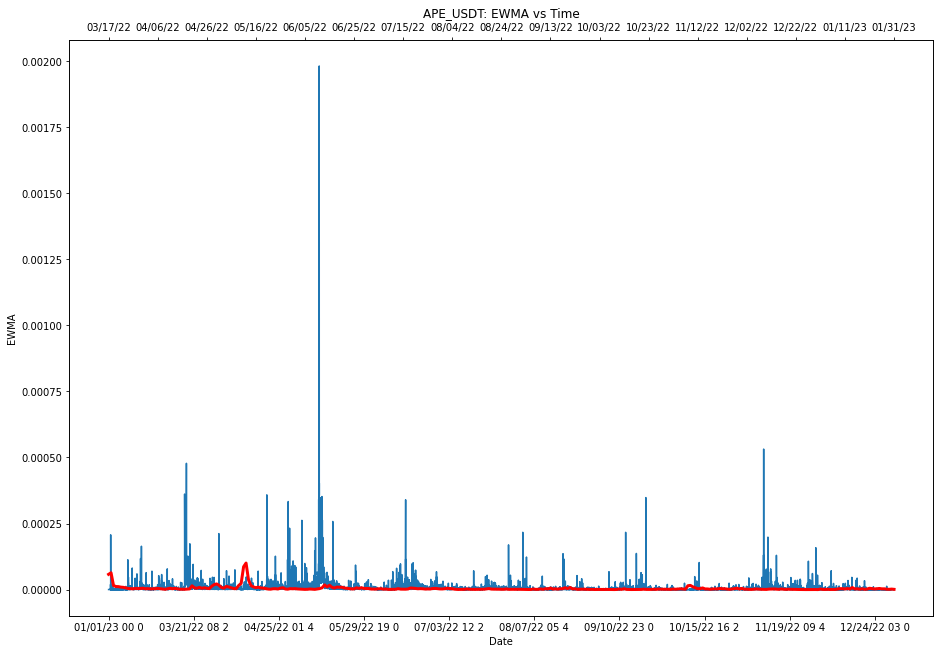

In [27]:
local_path = 'C:/Users/Dylan Celli/Documents/sorrentum_research/clean_binance.csv'
binance_df = pd.read_csv(local_path)
chosen_bitcoin = 'APE_USDT'
(ten_min_ave, daily_ave) = EWMA_per_bitcoin(chosen_bitcoin,binance_df)
plot_bitcoin(chosen_bitcoin,ten_min_ave,daily_ave)